# EDA Notebook Spring 2024 ML Herbarium

## Internal Notes (Will organize before final PR)

### important notebooks:

ml-herbarium-mv/ml-herbarium/trocr/trocr_with_detr_label_extraction.ipynb

./cleaned_trocr_test.ipynb

vision/Mask_remove_text-3.ipynb

ml-herbarium-data-spring2023/TrOCR evaluation data/Evaluation_data_TrOCR.ipynb

fall2023/LLM_Evaluation-Chinese.ipynb

### Home Directory:
/projectnb/sparkgrp/ml-herbarium-grp/spring2024

# Background

This is an multi-semester projects, where our team's progress, please start from here:

https://github.com/BU-Spark/ml-herbarium/blob/dev/Spring2024/Technical%20Project%20Document.md



# Chinese Herberium Specimen

Learning from higher inaccuracies in Chinese handwritten, our team team wants to improve local model's performances so it could accurately extract the necessary heberia texts.

Data Source:

[Chinese Virtual Herbarium](https://www.cvh.ac.cn/)

Sample Query:

https://www.cvh.ac.cn/spms/detail.php?id=e6f65c3e

<img src="https://www.cvh.ac.cn/controller/spms/image.php?institutionCode=PE&catalogNumber=02248865" width="800">

# TrOCR with DETR

## Label Extraction with DETR

DETR (Detection Transformer) is utilized to detect and extract labels from images. This process involves identifying regions of the image that likely contain text, which are considered potential labels. Images without detected bounding boxes are removed from further processing, ensuring only images with potential text labels proceed.

## Text Segmentation with CRAFT

Text Segmentation: Following DETR's label detection, the CRAFT (Character Region Awareness for Text detection) model segments the detected labels into individual characters or words. This step is critical for improving the accuracy of the subsequent text recognition process.

Data Preparation for TrOCR: The segmented images are organized into a dataloader, and the TrOCR model along with its processor is loaded. This preparation involves cleaning the data further by removing empty folders.

## Text Recognition with TrOCR

Text Recognition: TrOCR is then applied to the segmented images to recognize and transcribe the text. The outputs are stored, and preliminary results are compiled into a CSV file for analysis. This includes the recognized text, its confidence level, and the labels assigned by the TrOCR model.

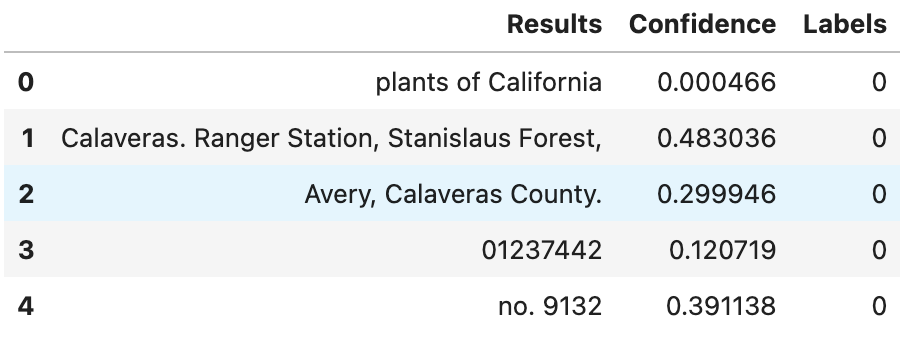

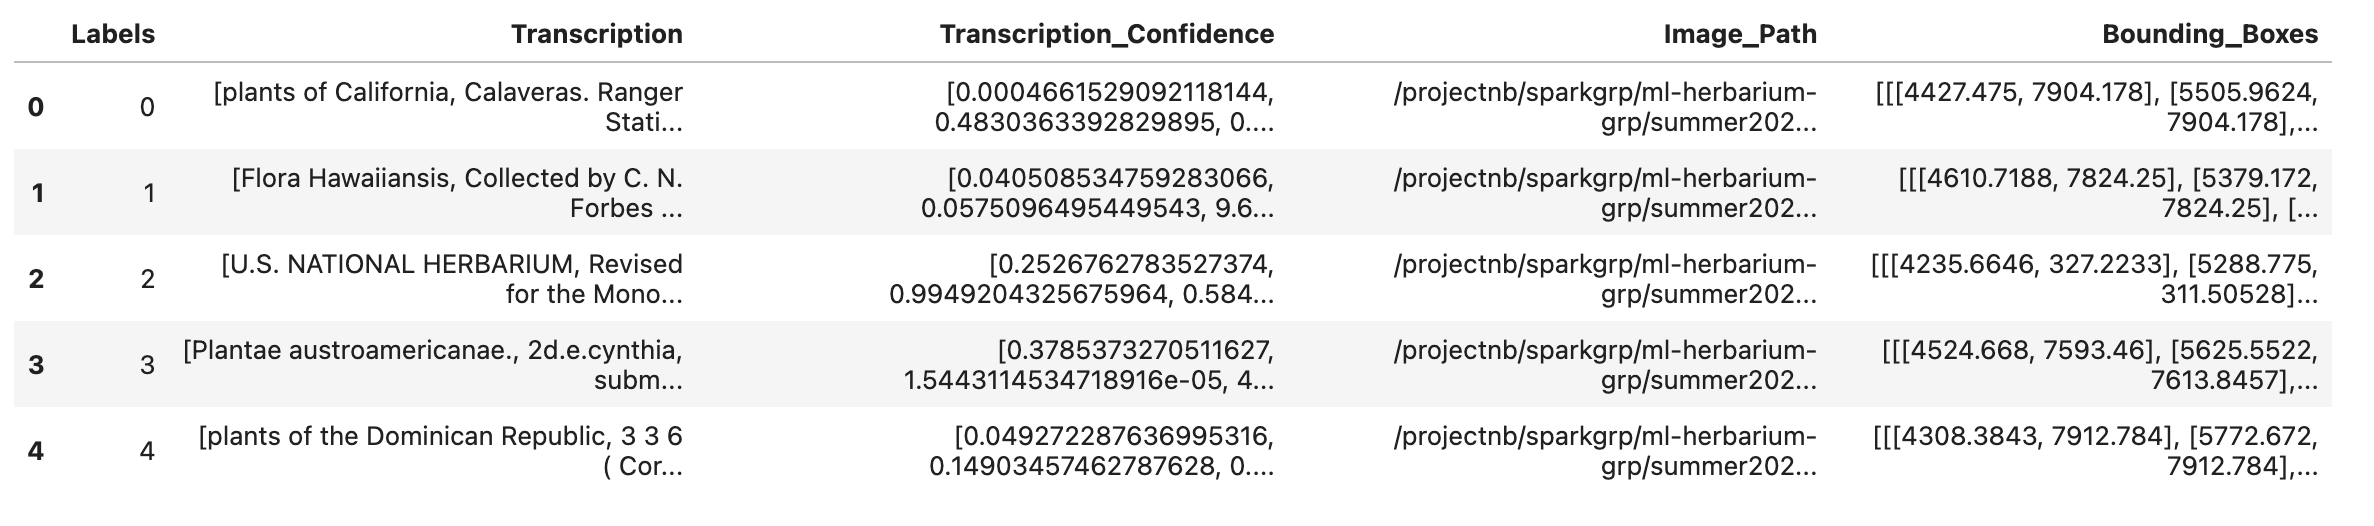

## Ground Truth Comparison and Entity Recognition

Comparing with Ground Truth: The notebook progresses to compare the recognized text against a set of ground truth values for a sample of tested images. 

Taxonomic Entity Recognition: Using TaxoNERD, the notebook attempts to identify taxonomic entities from the detected text. This process is further expanded upon by using additional NLP tools for recognizing dates and locations, potentially providing contextual clues that improve taxonomic name recognition.

Final Analysis: The notebook concludes with an analysis of the results, including comparisons before and after integrating DETR, and between handwritten and typed text. These comparisons aim to illustrate the improvements in accuracy and efficiency achieved through the applied methods.

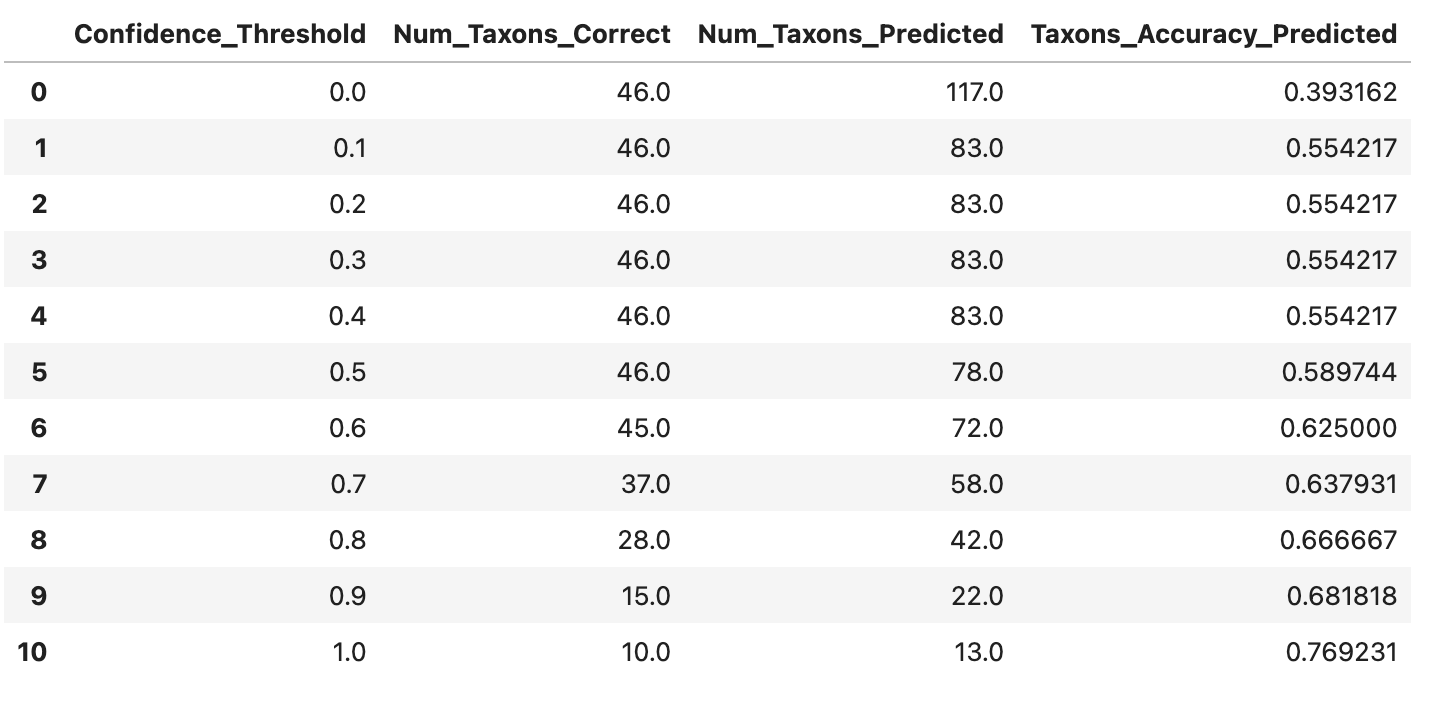

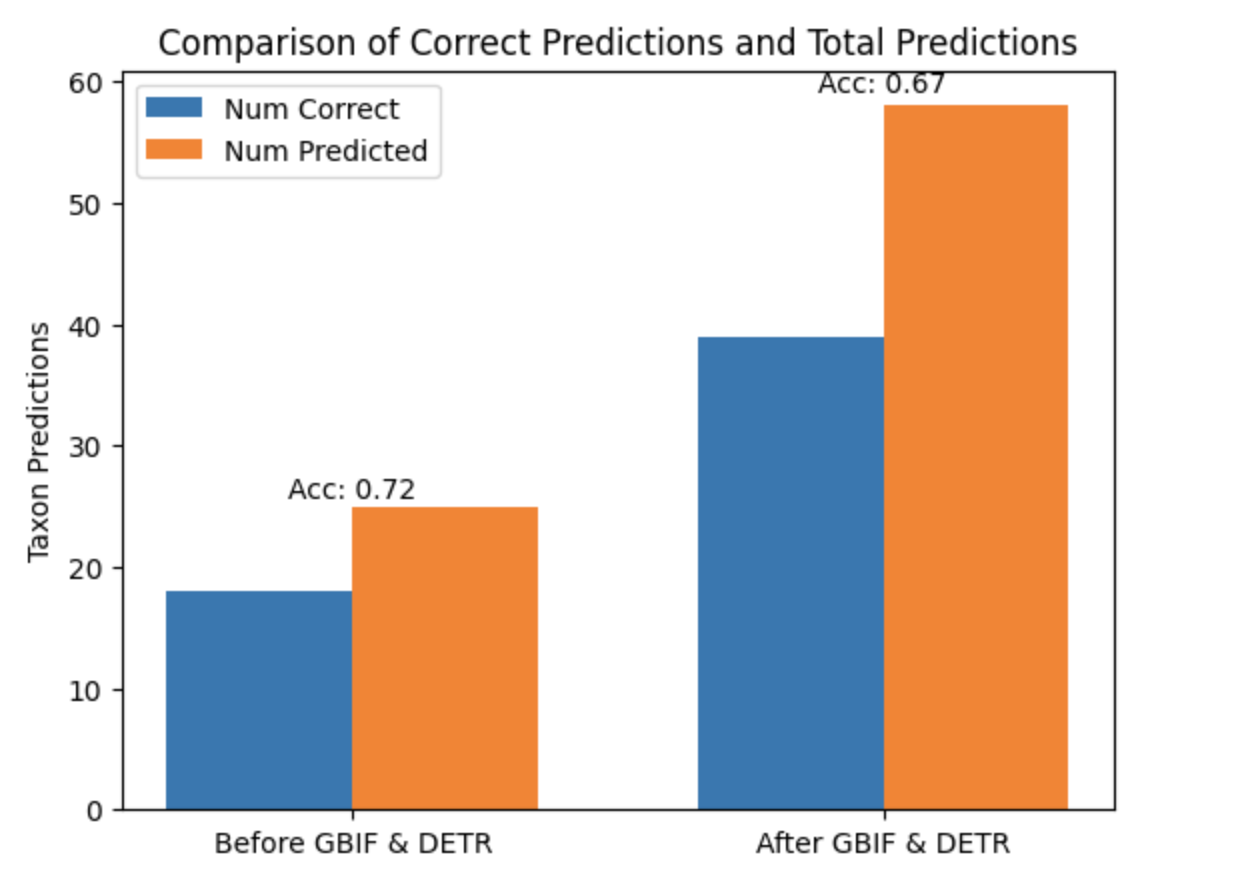

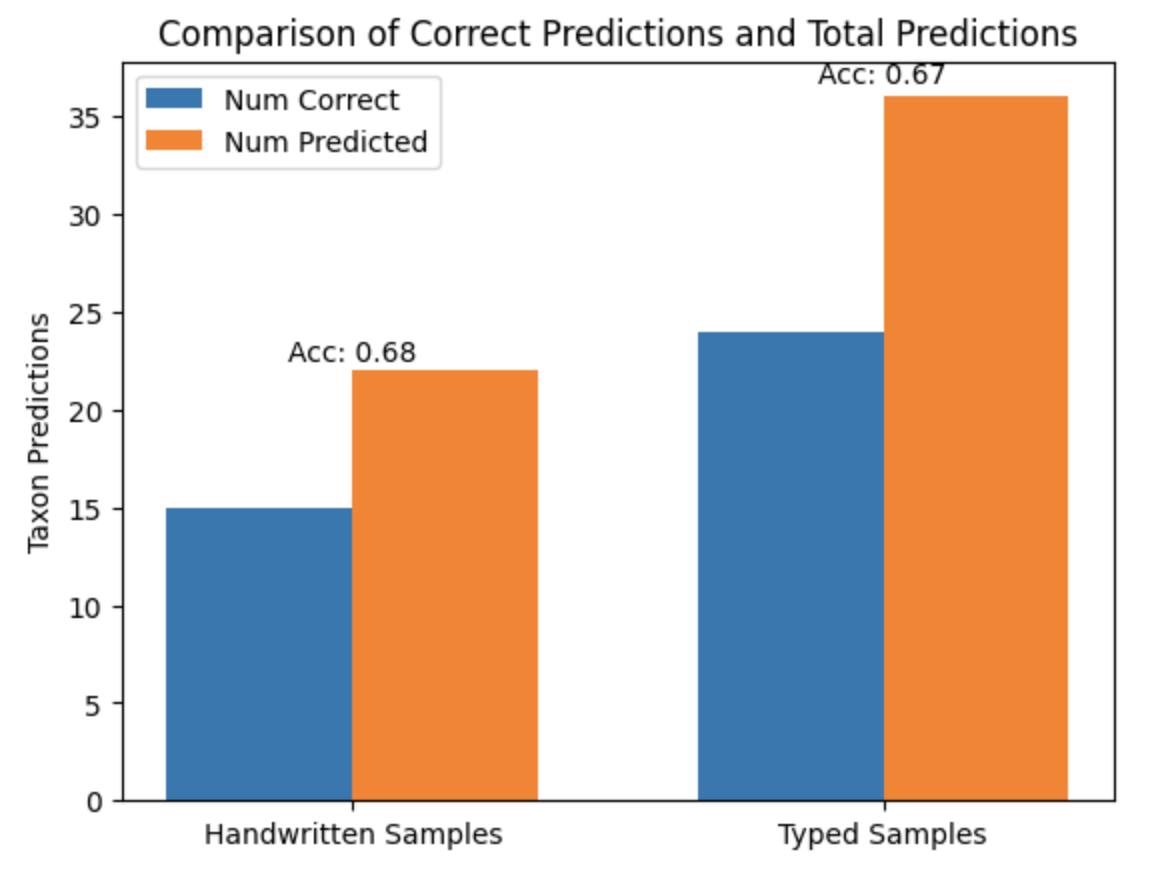

## GBIF Dataset Scraping

In [1]:
pip install python-dwca-reader

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import shutil
import os
import time
import math
import pandas
import json
from tqdm import tqdm
import glob
import random
from PIL import Image
import imghdr

import multiprocessing as mp
NUM_CORES = min(mp.cpu_count(), 50)

import numpy as np
import matplotlib.pyplot as plt
import cv2

from dwca.read import DwCAReader
from dwca.darwincore.utils import qualname as qn

/scratch/5361756.1.academic/ipykernel_1765269/34724052.py:12: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


### Loading the GBIF Dataset

In [3]:
# this will take a while (but less than 5 minutes)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv("//projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/data.csv", sep="\t")
DATASET_TYPE = "csv"
colnames = []
for col in df.columns:
    colnames.append(col)
print(f"colnames: {colnames}")
print(f"df.shape: {df.shape}")

/scratch/5361756.1.academic/ipykernel_1765269/1435020605.py:6: DtypeWarning: Columns (2,14,16,17,19,21,24,25,26,32,33,34,36,37,38,39,40,41,43,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("//projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/data.csv", sep="\t")


colnames: ['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'infraspecificEpithet', 'taxonRank', 'scientificName', 'verbatimScientificName', 'verbatimScientificNameAuthorship', 'countryCode', 'locality', 'stateProvince', 'occurrenceStatus', 'individualCount', 'publishingOrgKey', 'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation', 'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day', 'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord', 'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber', 'identifiedBy', 'dateIdentified', 'license', 'rightsHolder', 'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted', 'mediaType', 'issue']
df.shape: (7982741, 50)


In [4]:
df = df.sort_values(by='species')
df.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
6228346,1638360008,b89a7f02-021d-4e7a-b19f-575d10578a6d,NaN,Plantae,Tracheophyta,Liliopsida,Asparagales,Orchidaceae,Aa,Aa achalensis,...,NaN,NaN,CC_BY_4_0,NaN,"Hieronymus, G. (no. 796)",SYNTYPE,NaN,2022-01-29T18:57:50.596Z,StillImage,INSTITUTION_MATCH_FUZZY;COLLECTION_MATCH_NONE
3741256,2575063623,861e6afe-f762-11e1-a439-00145eb45e9a,781823f5-aab8-4cd8-b4c8-1578289c842a,Plantae,Tracheophyta,Liliopsida,Asparagales,Orchidaceae,Aa,Aa argyrolepis,...,NaN,NaN,CC_BY_4_0,President and Fellows of Harvard College,M. Bang,NaN,NaN,2022-03-26T23:44:02.259Z,StillImage,COLLECTION_MATCH_FUZZY
1399147,2575095083,861e6afe-f762-11e1-a439-00145eb45e9a,d3a05336-37b2-468d-9973-3e15e3e7f25f,Plantae,Tracheophyta,Liliopsida,Asparagales,Orchidaceae,Aa,Aa argyrolepis,...,NaN,NaN,CC_BY_4_0,President and Fellows of Harvard College,M. Lillo,NaN,NaN,2022-03-26T23:44:03.328Z,StillImage,COLLECTION_MATCH_FUZZY
5707980,1930313762,d415c253-4d61-4459-9d25-4015b9084fb0,b4232e5d-e766-47d0-906e-02a458440eec,Plantae,Tracheophyta,Liliopsida,Asparagales,Orchidaceae,Aa,Aa calceata,...,NaN,NaN,CC0_1_0,The New York Botanical Garden,G. Mandon,ISOTYPE,NaN,2022-03-26T17:27:22.518Z,StillImage,COLLECTION_MATCH_FUZZY
392067,1998418826,861e6afe-f762-11e1-a439-00145eb45e9a,1a7c9380-cf19-4f48-bfb4-d6476428f1f3,Plantae,Tracheophyta,Liliopsida,Asparagales,Orchidaceae,Aa,Aa calceata,...,NaN,NaN,CC_BY_4_0,President and Fellows of Harvard College,G. Mandon,ISOTYPE,NaN,2022-03-26T23:42:56.681Z,StillImage,COLLECTION_MATCH_FUZZY


In [5]:
x = df['genus'].value_counts()
print(f"{len(x)} total entries with genus")
x

15462 total entries with genus


genus
Carex            228853
Salix             78596
Euphorbia         60624
Juncus            57851
Viola             49885
                  ...  
Hypoxidia             1
Loefflingia           1
Pedaliodiscus         1
Herpetium             1
Desmia                1
Name: count, Length: 15462, dtype: int64

### Scraping (keep small for quick sample)

In [6]:
data = {}

# keep below 0.0001 for reasonable times
PERCENT_TO_SCRAPE = 0.00025
NUMBER_TO_SKIP = math.floor(df.shape[0] / (df.shape[0] * PERCENT_TO_SCRAPE))
NUMBER_TO_SCRAPE = math.ceil(df.shape[0] / NUMBER_TO_SKIP)
print(str(NUMBER_TO_SCRAPE) + " IDs will be scraped.")

for i in range(1, df.shape[0], NUMBER_TO_SKIP):
    if DATASET_TYPE == "dwca":
        id = df.at[i, "id"]
    elif DATASET_TYPE == "csv":
        id = df.at[i, "gbifID"]
    data[i] = {"id": str(id)}
print("Successfully scraped " + str(len(data)) + " IDs.")

1996 IDs will be scraped.
Successfully scraped 1996 IDs.


### Fetching images with GBIF API

In [7]:
# can be long (>30 mins) depending on scrape size
# scraping ~400 for notebook submission sample

def scrape_occurrence(key):
    try:
        rq = requests.get("https://api.gbif.org/v1/occurrence/" + str(data[key]["id"]))
        # catch http error
        rq.raise_for_status()
        # attempt json decode
        content = json.loads(rq.content)
        return_dict = {key: {}}
        
        if 'media' in content and content["media"]:
            media = content["media"][0]
            return_dict[key]["img_url"] = media.get("identifier", None)
            return_dict[key]["img_type"] = media.get("format", None)
        else:
            return None

        # important info storage (ground truth)
        return_dict[key]["country"] = content.get("country", None)
        return_dict[key]["genus"] = content.get("genus", None)
        return_dict[key]["species"] = content.get("species", None)
        return_dict[key]["Collector"] = content.get("recordedBy", None)
        
        return return_dict if None not in return_dict[key].values() else None

    # bad URL and request error handling
    except requests.exceptions.HTTPError as e:
        print(f"HTTPError for key {key}: {e}")
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError for key {key}: {e}")
    except Exception as e:
        print(f"Unexpected error for key {key}: {e}")
    return None

scrape = {}
print("Fetching data...")
for key in tqdm(data.keys(), desc="Progress"):
    item = scrape_occurrence(key)
    if item is not None:
        scrape.update(item)

print("\nSuccessfully fetched data for", len(scrape), "occurrences.")

Fetching data...


Progress:   2%|▏         | 38/1996 [00:23<18:31,  1.76it/s]

HTTPError for key 148001: 404 Client Error: Not Found for url: https://api.gbif.org/v1/occurrence/912541788


Progress:  36%|███▌      | 720/1996 [07:38<13:20,  1.59it/s]

HTTPError for key 2876001: 404 Client Error: Not Found for url: https://api.gbif.org/v1/occurrence/3059552955


Progress:  58%|█████▊    | 1148/1996 [12:05<07:46,  1.82it/s]

HTTPError for key 4588001: 404 Client Error: Not Found for url: https://api.gbif.org/v1/occurrence/1252641782


Progress:  58%|█████▊    | 1149/1996 [12:06<07:30,  1.88it/s]

HTTPError for key 4592001: 404 Client Error: Not Found for url: https://api.gbif.org/v1/occurrence/912495080


Progress: 100%|██████████| 1996/1996 [20:37<00:00,  1.61it/s]


Successfully fetched data for 1472 occurrences.


### Species/country information and frequency

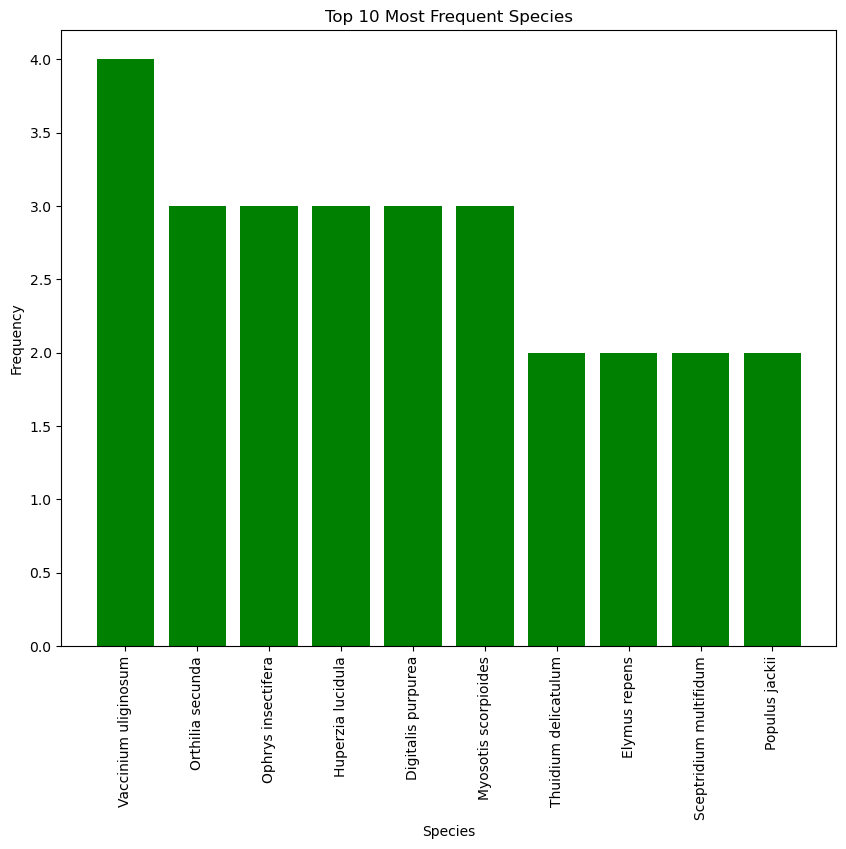

In [8]:
from collections import Counter

species_list = [scrape[key]["species"] for key in scrape if "species" in scrape[key]]
species_freq = Counter(species_list)

# max amount to show in chart
top_n = 10

top_species = species_freq.most_common(top_n)
species_names, frequencies = zip(*top_species)

plt.figure(figsize=(10, 8))
plt.bar(species_names, frequencies, color="green")
plt.xlabel('Species')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title(f'Top {top_n} Most Frequent Species')
plt.show()

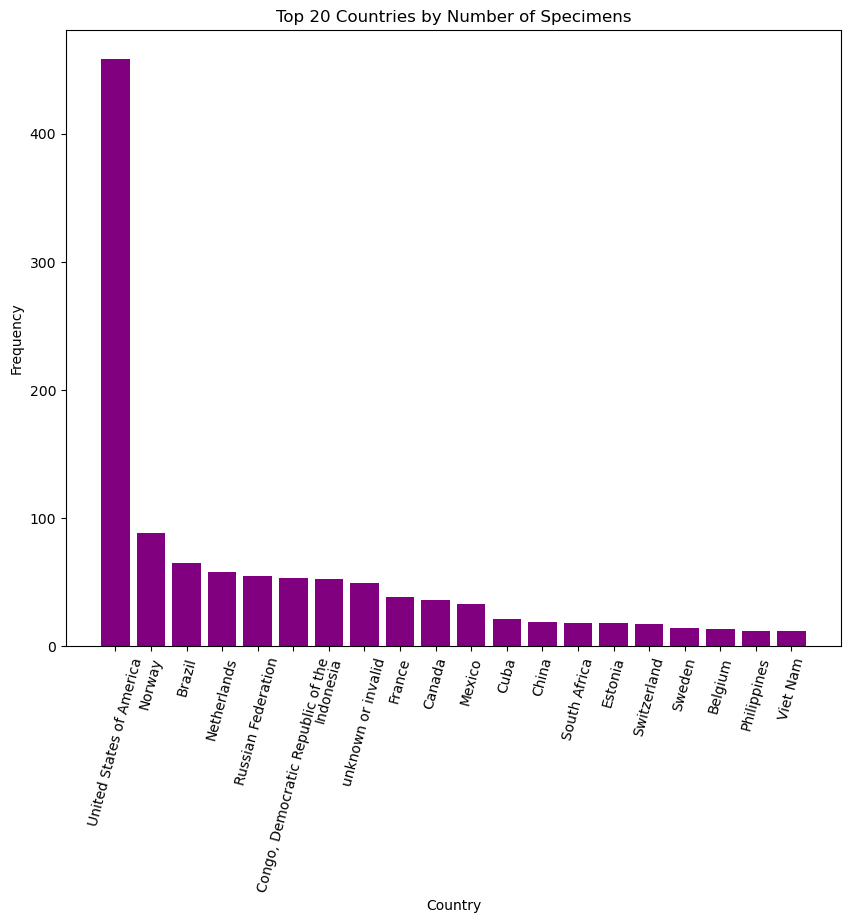

In [9]:
country_list = [value["country"] for key, value in scrape.items() if "country" in value]
country_freq = Counter(country_list)

top_n_countries = 20
top_countries = country_freq.most_common(top_n_countries)

countries, frequencies = zip(*top_countries)

plt.figure(figsize=(10, 8))
plt.bar(countries, frequencies, color='purple')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=75)
plt.title(f'Top {top_n_countries} Countries by Number of Specimens')
plt.show()

### View sample scraped image

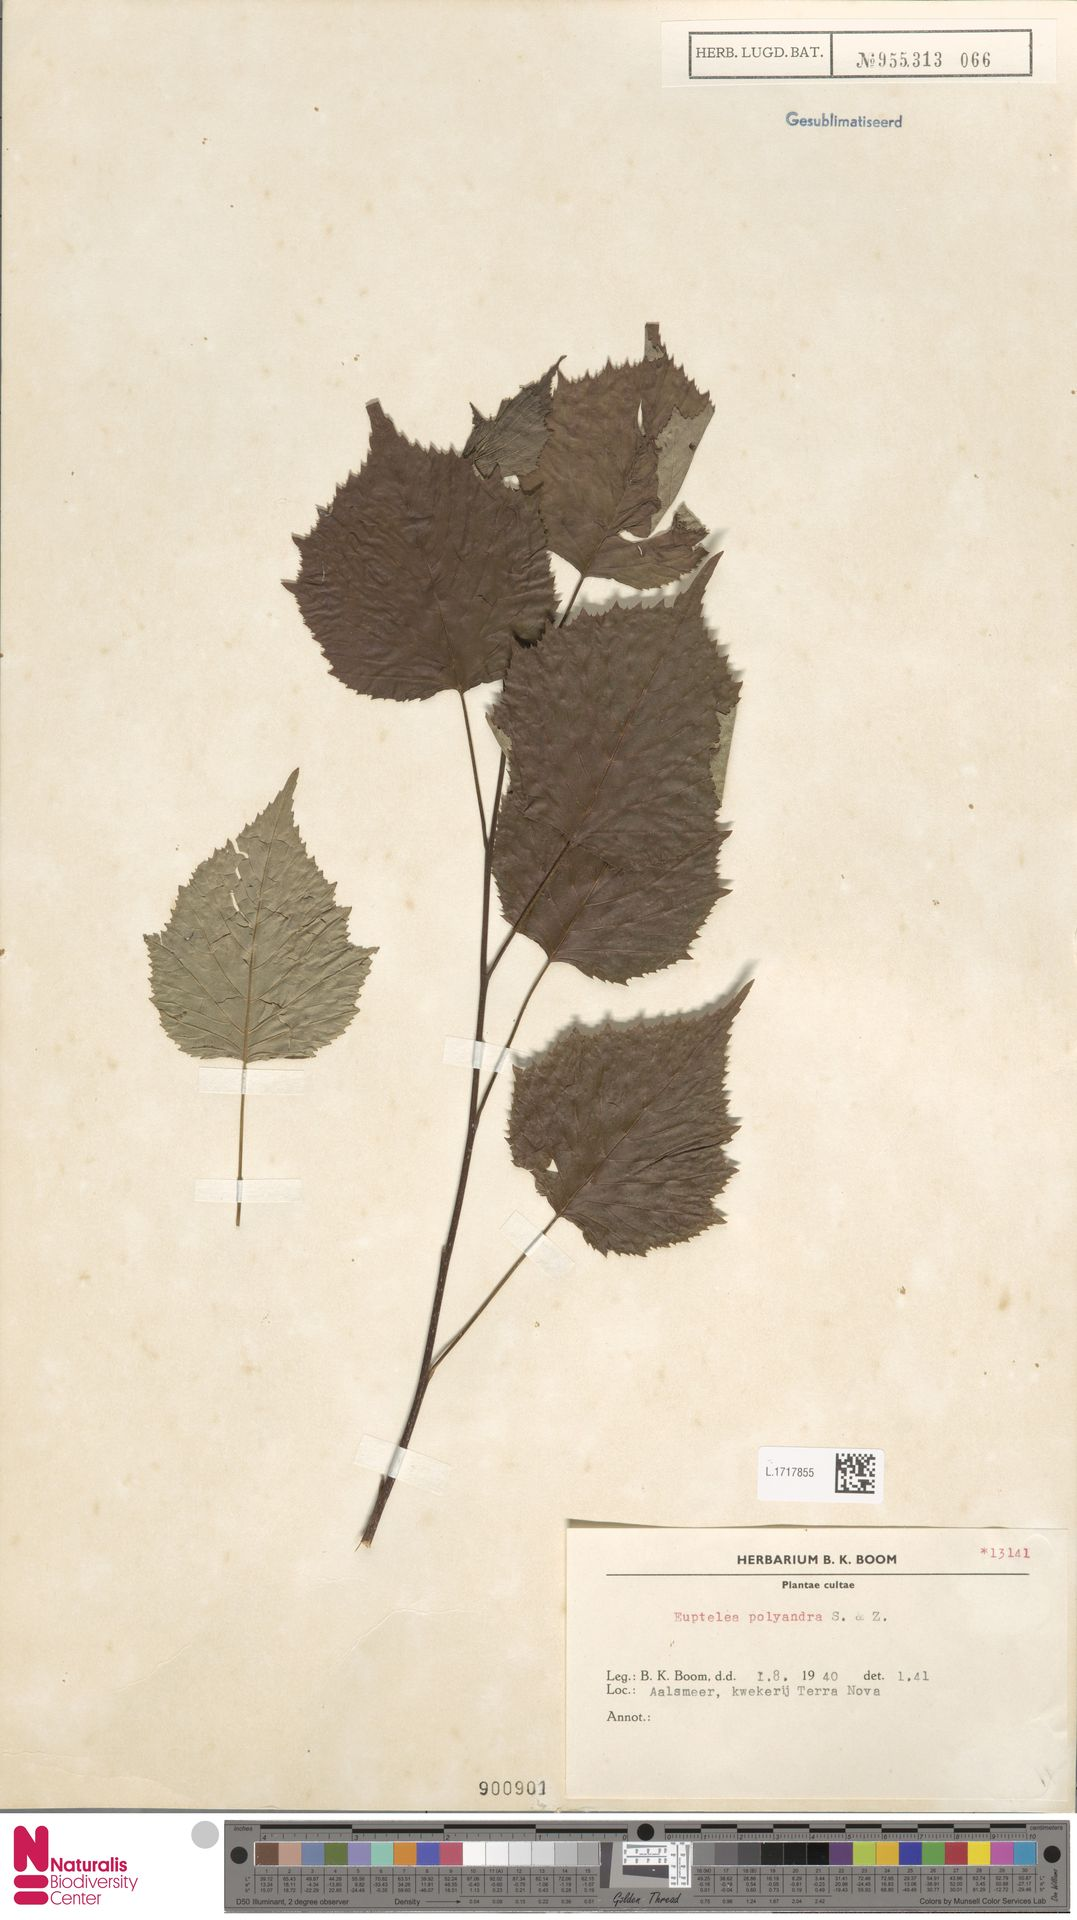

In [10]:
from IPython.display import display, Image

img_url = scrape[key]["img_url"]
img = requests.get(img_url, stream=True, timeout=10)

if img.status_code == 200:
    display(Image(img.content))
else:
    print(f"Failed to fetch image from {img_url}")

# CVH Dataset

## News Article from CVH

The article is written in Chinese, and below is the summary:


"截止目前，资源库在线共享数字化标本数据共计843余万份，标本照片669余万份。标本记录来自中科院系统等国内118家重要植物标本馆，覆盖中国83.52%的植物，共计492科3879属36209种。"

"So far (Dec. 2023), the resource library has shared more than 8.43 million digital specimen data and more than 6.69 million specimen photos online. Specimen records come from 118 important domestic herbaria including the Chinese Academy of Sciences system, covering 83.52% of China's plants, totaling 492 families and 3879 genera. 36209 species."



## CVH Sample Geological Distribution

The legend below indicates sample counts.

<img src="https://www.cvh.ac.cn/public/uploaded/images/20240124vRP3KLaz.png" width="800">

# CVH Dataset Scraping

## Why Scrapping?

As discussed, the CVH Dataset does not offer API access and thus a scrapper is needed. We will show the PoC of Scrapping when needed. 

## Use of Selenium
The CVH ddatabase has dynamic element (JS), thus need the use of selenium.
The SCC is a virutal machine and lacks the normal browser support, so we could
* Use SCC's virtual machine or local machines build pipeline from there
* Figure out another way.

In [1]:
!pip install selenium webdriver_manager -q

On my end, this step usually takes 1.5 minutes to run.

## Use Selenium to fetch the catalogue
The CVH page currently shows a list of 30 items so it will be offsetted by 30/60/90

Should modify the logic to support concurrencies

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

# Set up Selenium WebDriver
# service = Service(ChromeDriverManager().install())
# driver = webdriver.Chrome(service=service)

# Alternative
# Set up Chrome options for headless execution
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Set up Selenium WebDriver with headless Chrome
driver = webdriver.Chrome(options=chrome_options)

# URL to scrape
# The CVH page shows a list of 30 items so it will be offsetted by 30/60/90
# url = "https://www.cvh.ac.cn/spms/list.php?&offset=0"

base_url = "https://www.cvh.ac.cn/spms/list.php?&offset="

data_collection_ids = []

# Iterate through the pages to fetch the top 300 responses (10 pages x 30 items per page)
for offset in range(0, 300, 30):
    # Modify the URL to include the current offset
    url = base_url + str(offset)
    
    # Open the URL
    driver.get(url)

    # Wait for the dynamic content to load
    time.sleep(5)  # Adjust the sleep time according to your internet speed and website response

    # Find all elements with the specified class
    rows = driver.find_elements(By.CLASS_NAME, 'spms-row')

    # Extract data-collection-id from each row and append to the list
    for row in rows:
        data_collection_ids.append(row.get_attribute('data-collection-id'))

# Close the WebDriver
driver.quit()

# Create a DataFrame
data_collection_ids  = pd.DataFrame(data_collection_ids, columns=['Data Collection ID'])

# Display the DataFrame
data_collection_ids

,Data Collection ID
0,e6e73365
1,e6e73489
2,e6e73514
3,e6e7359d
4,e6e73625
...,...
295,e6e7d3cc
296,e6e7d455
297,e6e7d4de
298,e6e7d567


## Sample Dataframe

The sample dataframe is used for a placeholder before we setup a headless driver to run on a virtual machine. 

In [22]:
# data = {
#     "Data Collection ID": [
#         "e6e73365", "e6e73489", "e6e73514", "e6e7359d", "e6e73625",
#         "e6e736ae", "e6e73738", "e6e737c0", "e6e73847", "e6e738ce",
#         "e6e7395a", "e6e739e8", "e6e73a6f", "e6e73af6", "e6e73b7e",
#         "e6e73c07", "e6e73c8f", "e6e73d18", "e6e73da0", "e6e73e2b",
#         "e6e73eb9", "e6e73f42", "e6e73fc9", "e6e74052", "e6e740da",
#         "e6e74162", "e6e741eb", "e6e74274", "e6e742fc", "e6e74389"
#     ]
# }

# # Convert the dictionary to a DataFrame
# data_collection_ids = pd.DataFrame(data)

## Use Selenium to Fetch Hebaria Data

### Scraped Info

Given a page's id, we could scrape the image link and the corresponding label/ground truth value.
See the red-rectangle for the corresponding elements from the screen shot of this page: https://www.cvh.ac.cn/spms/detail.php?id=e6e73365

Input:
* page_id (e.g. e6e73365)

Output:
* Image link
* Label data on right
    * Taxon classification tree (Phylum/Order/Family/Genus)
    * Identification Information
        * Scientific Name
        * Chinese Name
        * Identifier
        * Identification Time
    * Collection Information
        * Collector
        * Collection Number
        * Collection Time
        * Collection Place
        * Altitude (meter)
        * Habitat
        * Habits
        * Phenological Stage

<img src="cvh_images/cvh_e6e73365_screenshot.png" width="800">

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from webdriver_manager.chrome import ChromeDriverManager
import concurrent
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import pandas as pd
import time
import os

def setup_driver(headless=True):
    chrome_options = Options()
    if headless:
        chrome_options.add_argument("--headless")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

def wait_for_element(driver, by_method, value, timeout=10, retry_interval=5, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            return WebDriverWait(driver, timeout).until(EC.presence_of_element_located((by_method, value)))
        except TimeoutException:
            print(f"Retry {retries+1}/{max_retries} for element {value} after timeout.")
            time.sleep(retry_interval)
            retries += 1
        finally:
            print(f"Retry {retries+1}/{max_retries} for element {value} after timeout.")
            time.sleep(retry_interval)
    # raise TimeoutException(f"Element {value} not found after {max_retries} retries.")
    return "Missing Value or Timeout"  # Return None if element is not found

def fetch_data(collection_id):
    driver = setup_driver()
    try:
        print(f"Fetching data for collection: {collection_id}\n.")
        driver.get(f"https://www.cvh.ac.cn/spms/detail.php?id={collection_id}")
        
        # Fetch specific details as per your logic
        data = {
            'Collection ID': collection_id,
            'Image Link': wait_for_element(driver, By.ID, "spm_image", max_retries=5).get_attribute('src'),
            'Phylum (门)': wait_for_element(driver, By.ID, "taxon_phy_c", max_retries=5).text,
            'Order (目)': wait_for_element(driver, By.ID, "taxon_ord_c", max_retries=5).text,
            'Family (科)': wait_for_element(driver, By.ID, "taxon_fam_c", max_retries=5).text,
            'Genus (属)': wait_for_element(driver, By.ID, "taxon_gen_c", max_retries=5).text,
            'Scientific Name': wait_for_element(driver, By.ID, "formattedName", max_retries=5).text,
            'Chinese Name': wait_for_element(driver, By.ID, "chineseName", max_retries=5).text,
            'Identified By': wait_for_element(driver, By.ID, "identifiedBy", max_retries=5).text,
            'Date Identified': wait_for_element(driver, By.ID, "dateIdentified", max_retries=5).text,
            'Collector': wait_for_element(driver, By.ID, "recordedBy", max_retries=5).text,
            'Collection Number': wait_for_element(driver, By.ID, "recordNumber", max_retries=5).text,
            'Collection Date': wait_for_element(driver, By.ID, "verbatimEventDate", max_retries=5).text,
            'Collection Location': wait_for_element(driver, By.ID, "locality", max_retries=5).text,
            'Altitude': wait_for_element(driver, By.ID, "elevation", max_retries=5).text,
            'Habitat': wait_for_element(driver, By.ID, "habitat", max_retries=5).text,
            'Phenology': wait_for_element(driver, By.ID, "reproductiveCondition", max_retries=5).text
        }
        return data
    finally:
        driver.quit()

def fetch_collection_data_concurrently(collection_ids, max_workers=5):
    results = []
    
    # Initialize an empty DataFrame to hold column names. This is useful if you expect your first few calls might fail and return None.
    temp_path = "./scraper_results/temp_results.csv"
    pd.DataFrame(columns=['Collection ID', 'Image Link', 'Phylum (门)', 'Order (目)', 'Family (科)', 
                          'Genus (属)', 'Scientific Name', 'Chinese Name', 'Identified By', 
                          'Date Identified', 'Collector', 'Collection Number', 'Collection Date', 
                          'Collection Location', 'Altitude', 'Habitat', 'Phenology']).to_csv(temp_path, mode='w', index=False, encoding='utf-8-sig')

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(fetch_data, cid) for cid in collection_ids]
        for future in tqdm(as_completed(futures), total=len(collection_ids)):
            results.append(future.result())
            result = future.result()
            if result:
                # Append the result to the CSV file
                try:
                    pd.DataFrame([result]).to_csv(temp_path, mode='a', header=False, index=False, encoding='utf-8-sig')
                except PermissionError:
                    continue

    df = pd.DataFrame(results)
    return df

## Web Scraper Results

In [23]:
!pwd

/projectnb/sparkgrp/ml-herbarium-grp/spring2024


In [4]:
pd.set_option('display.max_columns', None)

sample_collections = list(data_collection_ids['Data Collection ID'])
results = fetch_collection_data_concurrently(sample_collections, 30) 
results_path = "./scraper_results/results.csv"
results.to_csv(results_path, header=True, index=False, encoding='utf-8-sig')
results

  0%|          | 0/300 [00:00<?, ?it/s]

Fetching data for collection: e6e74052
.
Fetching data for collection: e6e73847
.
Fetching data for collection: e6e736ae
.
Fetching data for collection: e6e73514
.
Fetching data for collection: e6e73a6f
.
Fetching data for collection: e6e7395a
.
Fetching data for collection: e6e741eb
.
Fetching data for collection: e6e73c8f
.
Fetching data for collection: e6e738ce
.
Fetching data for collection: e6e73365
.
Fetching data for collection: e6e73489
.
Fetching data for collection: e6e73c07
.
Fetching data for collection: e6e73af6
.
Fetching data for collection: e6e73625
.
Fetching data for collection: e6e73b7e
.
Fetching data for collection: e6e73d18
.
Fetching data for collection: e6e73fc9
.
Fetching data for collection: e6e74389
.
Fetching data for collection: e6e73e2b
.
Fetching data for collection: e6e740da
.
Fetching data for collection: e6e737c0
.
Fetching data for collection: e6e742fc
.
Fetching data for collection: e6e7359d
.
Fetching data for collection: e6e74274
.
Fetching data fo

AttributeError: 'str' object has no attribute 'text'

In [ ]:
results

### Scrapper Results

Here is the screenshot from my local environment:

<img src="cvh_images/cvh_scrapper_sample_run.jpg" width="800">